In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.linalg import sqrtm
from scipy.special import gamma, digamma, loggamma

In [2]:
def softmax(x, axis=-1):
    """Compute softmax values for each sets of scores in x."""
    e_x = np.exp(x - np.max(x, axis=axis, keepdims=True))
    return e_x / np.sum(e_x, axis=-1, keepdims=True)

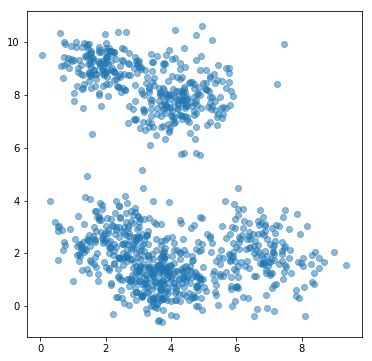

In [15]:
original_K = 5
DIM = 2
N = 1000

# create a dataset

pis = softmax(np.random.rand(original_K))
means = np.random.rand(original_K, DIM) * 10
variances = np.random.rand(original_K)

X = []
for _ in range(N):
    index = np.argmax(np.random.multinomial(1, pis))
    mean = means[index]
    variance = variances[index]
    covariance = np.diag([variance, variance])
    X.append(np.random.multivariate_normal(mean, covariance))
    
X = np.array(X)
plt.figure(figsize=[6, 6])
plt.scatter(X[:, 0], X[:, 1], alpha=0.5)
plt.show()


In [16]:
##########
# E-step #
##########

# (10.64)
def get_E_muk_lambdak(D, X, beta_k, nu_k, W_k, m_k):
    return D / beta_k + nu_k * np.diag((X - m_k) @ W_k @ (X - m_k).T)

# (10.65)
def get_E_ln_lambda_k(nu_k, W_k, D):
    v1 = 0
    for i in range(1, D + 1):
        v1 += digamma((nu_k + 1. - i) / 2.)
    v2 = D * np.log(2.)
    v3 = np.log(np.linalg.det(W_k))

    return v1 + v2 + v3

# (10.66)
def get_E_ln_pi_k(alpha, alpha_k):
    v1 = digamma(alpha_k)
    v2 = digamma(sum(alpha))

    return v1 - v2



In [17]:
##########
# M-step #
##########

# get alpha
def get_alpha_k(alpha_0, N_k):
    return alpha_0 + N_k

# get N_k, x_k_bar, S_k
def get_N_k(r):
    return np.sum(r, axis=0)

def get_x_k_bar(x, r, N_k):
    return np.sum(x * r) / N_k

def get_S_k(x, x_k_bar, r, N_k):
    var1 = 0
    for n, x_n in enumerate(x):
        distance = (x_n - x_k_bar)
        var1 += r[n, k] * distance @ distance.T
    
    return var1 / N_k
    
# get beta_k, m_k, W_k, nu_k
# (10.60)
def get_beta_k(beta_0, N_k):
    return beta_0 + N_k

# (10.61)
def get_m_k(beta_0, beta_k, m_0, N_k, x_k_bar):
    return 1. / beta_k * (beta_0 * m_0 + N_k * x_k_bar)

# (10.62)
def get_W_k(W_0, N_k, S_k, beta_0, x_k_bar, m_0):
    v1 = np.linalg.inv(W_0)
    v2 = N_k * S_k
    v3 = beta_0 * N_k / (beta_0 + N_k) * (x_k_bar - m_0) @ (x_k_bar - m_0).T

    return np.linalg.inv(v1 + v2 + v3)

# (10.63)
def get_nu_k(nu_0, N_k):
    return nu_0 + N_k + 1.


In [18]:
# The number of mixtures
K = 10
D = 2

# initialize parameters
alpha_0 = 1
m_0 = np.zeros(2)
beta_0 = 1.
W_0 = np.identity(D)
nu_0 = D

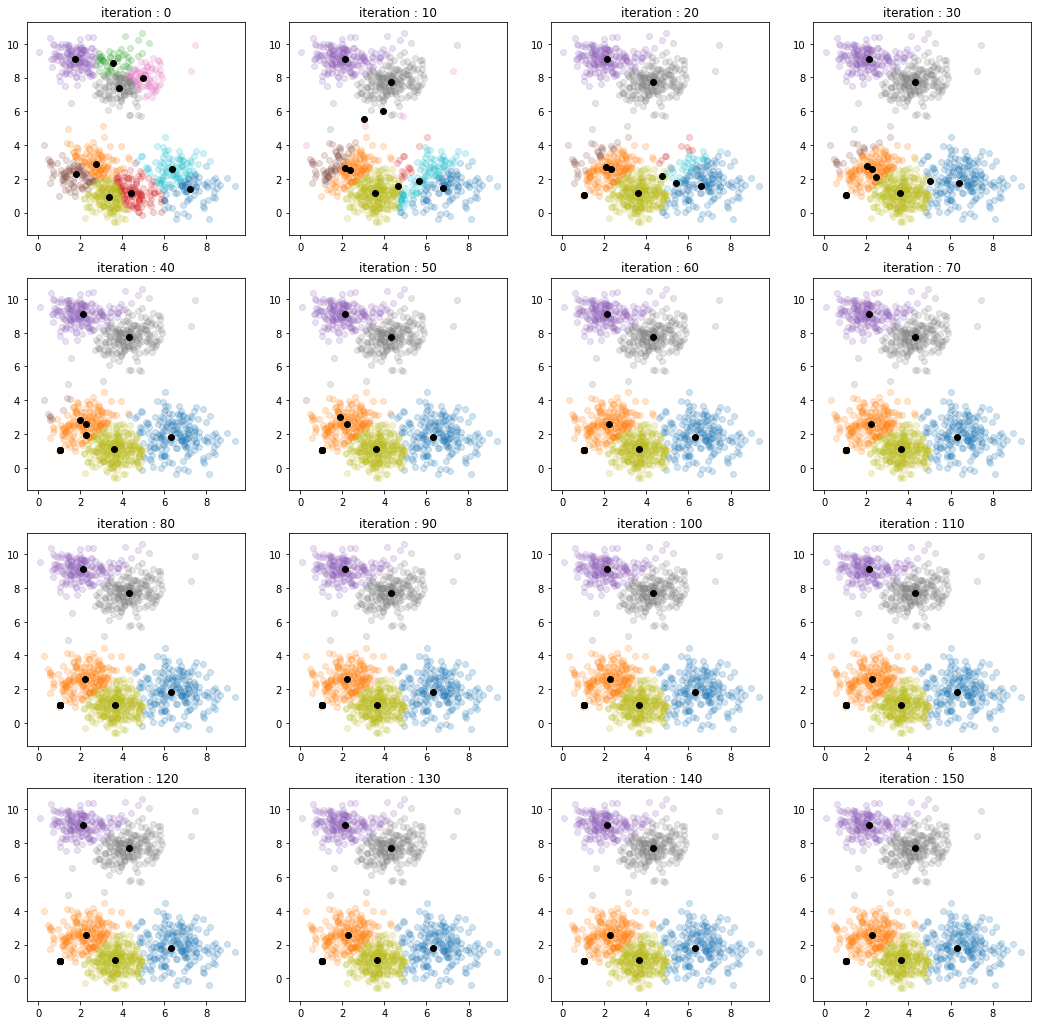

done


In [19]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=K, random_state=0).fit(X)

# initial guess 
# for p(pi)
alpha = np.ones(K)

# for p(mu, lambda)
m = kmeans.cluster_centers_ # initialize by KMeans
beta = np.ones(K)
W = [np.identity(D) for _ in range(K)]
nu = np.full(K, D)

plt.figure(figsize=[18, 18])
plot_num = 1

for iter_num in range(160):
    # E Step

    ro_k = []
    
    for k in range(K):
        E_ln_pi_k = get_E_ln_pi_k(alpha, alpha[k])
        E_ln_lambda_k = get_E_ln_lambda_k(nu[k], W[k], D)

        E_muk_lambdak = get_E_muk_lambdak(D, X, beta[k], nu[k], W[k], m[k])
        ro_k.append(E_ln_pi_k + 0.5 * E_ln_lambda_k - 0.5 * D * np.log(2. * np.pi) - 0.5 * E_muk_lambdak)
            
    ro = np.stack(ro_k, axis=-1)
    r = softmax(ro, axis=-1)

    # M step    
    N_ = np.sum(r, axis=0) # (10.51)
    x_bar = [None for _ in range(K)]
    S = [None for _ in range(K)]
    
    for k in range(K):
        x_bar[k] = np.sum(np.expand_dims(r[:, k], axis=-1) * X, axis=0) / N_[k] # (10.52)

        # (10.53)
        v1 = None
        for n in range(N):
            x_n = X[n]
            v2 = np.expand_dims(x_n - x_bar[k], axis=-1)
            if v1 is None:
                v1 = r[n, k] * v2 @ v2.T
            else:
                v1 += r[n, k] * v2 @ v2.T
        S[k] = v1 / N_[k]
        
    x_bar = np.stack(x_bar, axis=0)
    
    for k in range(K):
        alpha[k] = alpha_0 + N_[k]
        beta[k] = get_beta_k(beta_0, N_[k])
        m[k] = get_m_k(beta_0, beta[k], m_0, N_[k], x_bar[k])
        W[k] = get_W_k(W_0, N_[k], S[k], beta_0, x_bar[k], m_0)
        nu[k] = get_nu_k(nu_0, N_[k])

    if iter_num % 10 == 0:
        labels = np.argmax(r, axis=-1)
        plt.subplot(4, 4, plot_num)
        plt.title('iteration : ' + str(iter_num))
        plot_num += 1
        for k in range(K):
            plt.scatter(X[labels==k, 0], X[labels==k, 1], alpha=0.2)
        plt.scatter(x_bar[:, 0], x_bar[:, 1], color='black')
    
plt.show()
print('done')
